In [5]:
# %% [markdown]
# # Empirical Next-Token Entropy Distribution
# This notebook computes the distribution of next-token entropies for a pretrained language model (e.g., BERT, GPT-2) over a sliding window of length `k`.

# %%
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# %% [markdown]
# ## Parameters

# %%


# %% [markdown]
# ## Summary
# - `entropies` array contains the empirical next-token entropy values for each sliding window.
# - You can adjust `WINDOW_SIZE`, `MAX_TOKENS`, or the input `TEXT_SAMPLE` to explore different sequences.
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")


GPU Name: NVIDIA GeForce RTX 3070


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.
  0%|          | 0/1 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 1/1 [1:55:01<00:00, 6901.48s/it]
C:\Users\guost\AppData\Local\Temp\ipykernel_14044\309101512.py:117: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  {lbl:6s} : {cnt/counts.sum()}")
C:\Users\guost\AppData\Local\Temp\ipykernel_14044\309101512.py:120: RuntimeWarning: invalid value encountered in divide
  probs = counts / counts.sum()



Entropy Distribution:
  [0,1)  : nan
  [1,2)  : nan
  [2,3)  : nan
  [3,4)  : nan
  [4,5)  : nan
  [5,6)  : nan
  [6,7)  : nan
  [7,8)  : nan
  [8,9)  : nan
  [9,10) : nan
  [10,11) : nan
  [11,∞) : nan


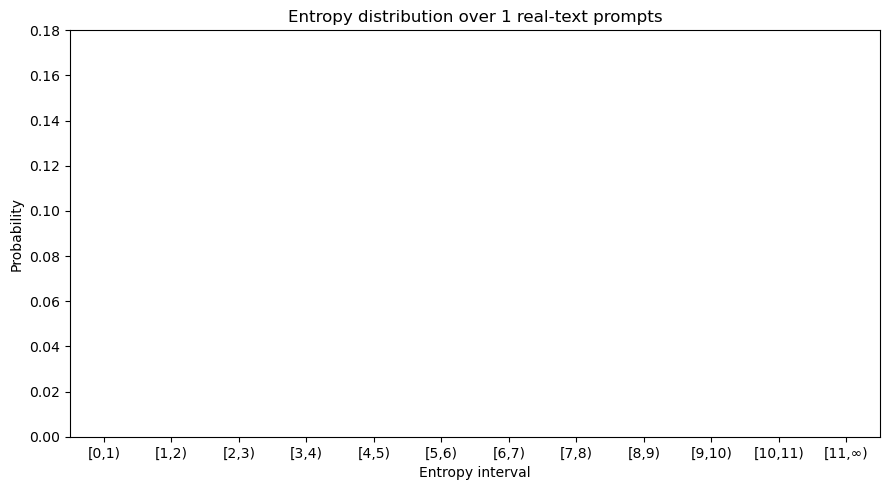

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM
from tqdm import tqdm

# ----------------------------
# Config
# ----------------------------
MODEL_NAME = "gpt2"

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",   # automatically puts model on GPU
    use_auth_token=True,
)
model.eval()


WINDOW_SIZE = 4
TOKENS_PER_PROMPT = 200
NUM_PROMPTS = 5

REAL_TEXT_SAMPLES = [
    "In a distant future, humanity has spread across the stars.",
    "The quick brown fox jumps over the lazy dog and runs into the forest.",
    "Mathematics provides a language for describing complex systems.",
    "The history of information theory begins with Claude Shannon.",
    "Artificial intelligence models learn patterns from massive datasets."
]

# ----------------------------
# Load model
# ----------------------------


device = "cuda" if torch.cuda.is_available() else "cpu"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# ----------------------------
# Helper: entropy (in bits)
# ----------------------------
# ----------------------------
# Helper: entropy (in bits)
# ----------------------------
def compute_next_token_entropy_bits(model, context_tokens):
    # context_tokens: 1D tensor of token ids on the correct device
    if context_tokens.numel() == 0:
        raise ValueError("compute_next_token_entropy_bits got an empty context_tokens tensor.")
    with torch.no_grad():
        logits = model(context_tokens.unsqueeze(0)).logits[0, -1, :]
        probs = torch.softmax(logits, dim=-1)
        entropy_nats = -(probs * (probs + 1e-12).log()).sum().item()
        return entropy_nats / np.log(2), probs.cpu().numpy()


# ----------------------------
# Main loop
# ----------------------------
all_entropies_bits = []

for _ in tqdm(range(NUM_PROMPTS)):
    real_text = np.random.choice(REAL_TEXT_SAMPLES)
    toks = tokenizer(real_text, return_tensors="pt")["input_ids"][0].to(device)

    # Skip super-short sequences
    if len(toks) < WINDOW_SIZE + 1:
        continue

    # Make sure we never pass negative max_new_tokens
    needed = max(0, TOKENS_PER_PROMPT - len(toks))
    if needed > 0:
        with torch.no_grad():
            extra = model.generate(
                toks.unsqueeze(0),
                max_new_tokens=needed,
                do_sample=True,
                top_p=0.9
            )[0]
        toks = extra.to(device)
    else:
        toks = toks[:TOKENS_PER_PROMPT]

    # Ensure we have at least WINDOW_SIZE tokens
    if len(toks) < WINDOW_SIZE + 1:
        continue

    # Sliding window
    for i in range(WINDOW_SIZE, TOKENS_PER_PROMPT):
        window = toks[i-WINDOW_SIZE:i]
        if window.numel() == 0:
            # Extra safety; this shouldn't happen now
            continue
        entropy_bits, _ = compute_next_token_entropy_bits(model, window)
        all_entropies_bits.append(entropy_bits)


all_entropies_bits = np.array(all_entropies_bits)

# ----------------------------
# Define entropy bins
# ----------------------------
bin_edges = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf])
bin_labels = np.array(["[0,1)", "[1,2)", "[2,3)", "[3,4)", "[4,5)", "[5,6)", "[6,7)", "[7,8)", "[8,9)", "[9,10)", "[10,11)", "[11,∞)"])

# Compute histogram counts (raw counts, not density)
counts, _ = np.histogram(all_entropies_bits, bins=bin_edges)

print("\nEntropy Distribution:")
for lbl, cnt in zip(bin_labels, counts):
    print(f"  {lbl:6s} : {cnt/counts.sum()}")

# Normalize to probability
probs = counts / counts.sum()

# ----------------------------
# Plot: equal visual width per bin (probabilities)
# ----------------------------
plt.figure(figsize=(9,5))

x_positions = np.arange(len(counts))  # 0..5

plt.bar(x_positions, probs, width=0.9, edgecolor="black", alpha=0.7)

# Fix axis scales (you can adjust)
plt.ylim(0, 0.18)        # since you're normalizing now
plt.xlim(-0.5, len(counts)-0.5)

plt.xticks(x_positions, bin_labels)
plt.xlabel("Entropy interval")
plt.ylabel("Probability")     # <-- this is now probability
plt.title(f"Entropy distribution over {NUM_PROMPTS} real-text prompts")
plt.tight_layout()
plt.show()


